## Step 1: Imports

In [1]:
import os
import numpy as np
import json
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

## Step 2: Path to the dataset after preprocessing

In [2]:
# paths
DATA_ROOT = r"E:\InstruNet-AI\data\post_preprocessing\irmas_mono"
NUM_CLASSES = 11

## Step 3: Class mapping loading

In [3]:
# class mapping (load exactly as before)
with open(r"E:\InstruNet-AI\data\splits\label_map.json", "r") as f:
    class_to_id = json.load(f)

In [4]:
def load_split(split_name):
    X, y = [], []
    split_dir = os.path.join(DATA_ROOT, split_name)

    for cls in os.listdir(split_dir):
        cls_id = class_to_id[cls]
        cls_dir = os.path.join(split_dir, cls)

        for file in os.listdir(cls_dir):
            if file.endswith(".npy"):
                mel = np.load(os.path.join(cls_dir, file))
                mel = mel[..., np.newaxis]  # (128, 126, 1)

                label = np.zeros(NUM_CLASSES, dtype=np.float32)
                label[cls_id] = 1.0

                X.append(mel)
                y.append(label)

    return np.array(X), np.array(y)

## Step 4: Loading the trained CNN Model

In [5]:
from tensorflow.keras.models import load_model

model = load_model(r"E:\InstruNet-AI\notebooks\best_instrunet.h5")

## Step 5: Loading Test Dataset

In [6]:
X_test, y_test = load_split("test")

## Step 6: Generating Prediction Probabilities

In [7]:
y_prob = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step


## Step 7: Plotting of ROC-AUC curve (AUC score per class)

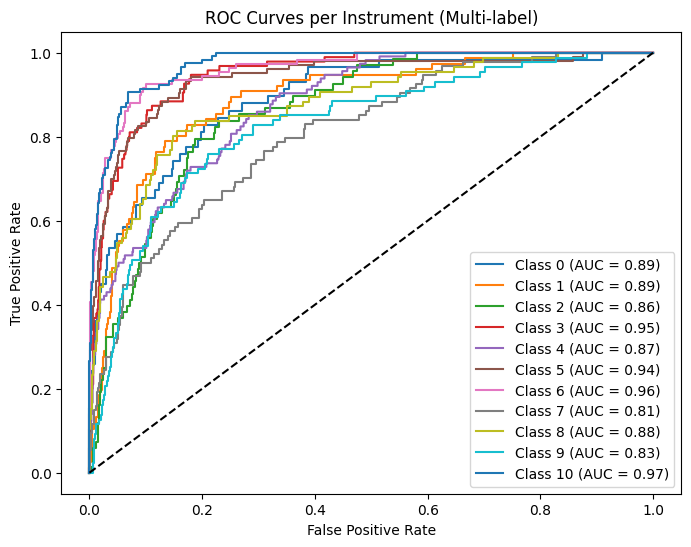

In [8]:
plt.figure(figsize=(8, 6))

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Instrument (Multi-label)")
plt.legend()
plt.show()

## Step 8: Micro-Averaged and Macro-Averaged F1 Score

In [9]:
micro_auc = roc_auc_score(y_test, y_prob, average="micro")
print("Micro-average ROC–AUC:", micro_auc)

Micro-average ROC–AUC: 0.9031095237718818


In [10]:
macro_auc = roc_auc_score(y_test, y_prob, average="macro")
print("Macro-average ROC–AUC:", macro_auc)

Macro-average ROC–AUC: 0.8953307954180413
